In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd

%matplotlib inline

mpl.rcParams["text.latex.preamble"] = r"\usepackage{siunitx}"

In [2]:
events = pd.read_csv("data/16-gestures/recordings/marten-12/events.csv")
labels = pd.read_csv("data/16-gestures/recordings/marten-12/labels.csv")

# Convert timestamps to seconds
events["timestamp"] /= 10**6
labels["start"] /= 10**6
labels["end"] /= 10**6

In [3]:
counts = events["polarity"].value_counts()
print(counts)
print("ON/OFF ratio: {}".format(counts[1] / counts[0]))

0    1562709
1     957721
Name: polarity, dtype: int64
ON/OFF ratio: 0.6128594639181063


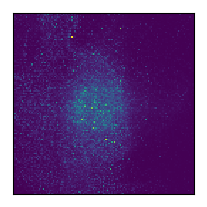

In [4]:
heatmap = np.ones((128, 128))
data = events.values
for i in range(len(data)):
    heatmap[127 - int(data[i, 2]), int(127 - data[i, 1])] += 1.0
    
fig, ax = pp.subplots(1, 1, dpi=96, figsize=(2.5, 2.5))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.imshow(heatmap)

In [5]:
heatmap_path = "../doc/figures/dataset/heatmap.png"
if not os.path.isfile(heatmap_path):
    pp.imsave(heatmap_path, heatmap, dpi=128)

In [6]:
def ewm(data, dt, halflife):
    """Compute an exponentially-weighted mean over the columns of data.

    """
    # Perform the calculations in double because it involves numbers pretty
    # close to 1 and 0 (consider halflife=10**6)
    columns = data.columns
    data = data.values.astype(np.float64)
    alpha = np.exp(np.log(0.5) / halflife)

    for i in range(1, data.shape[0]):
        decay = np.power(alpha, dt[i])

        # Maybe the second formulation is more numerically stable since there
        # is no multiplication with a number very close to 0.
        # data[i] = (1 - decay) * data[i] + decay * data[i - 1]
        data[i] = data[i] + decay * (data[i - 1] - data[i])

    return pd.DataFrame(data=data.astype(np.float32), columns=columns)

In [7]:
ts = events["timestamp"].values
dt = np.zeros(len(events), dtype=np.float32)
dt[1:] = ts[1:] - ts[:-1]
events["dt"] = dt

slow_mean = ewm(events[["x", "y"]], dt, halflife=1.0)
fast_mean = ewm(events[["x", "y"]], dt, halflife=50 * 10**(-3))

In [8]:
import matplotlib.transforms as mtrans
def plot_labels(labels, ax):
    trans = mtrans.blended_transform_factory(ax.transData, ax.transAxes)
    
    for _, l in labels.iterrows():
        ax.fill_between([l["start"], l["end"]], 0, 1, color="g", alpha=0.25, transform=trans)

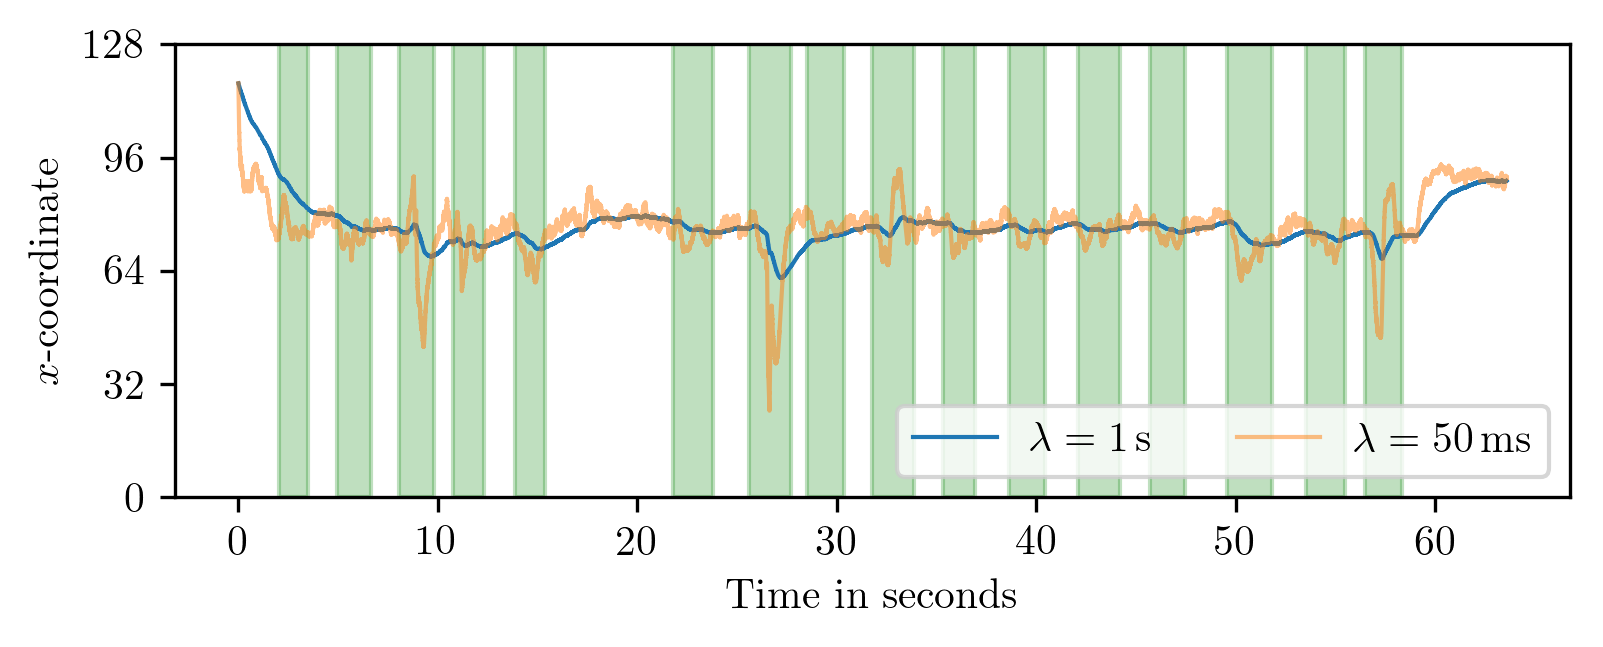

In [9]:
fig, ax = pp.subplots(1, 1, figsize=(6, 2), dpi=300)

ax.set_ylim(0, 127)
ax.set_yticks([0, 32, 64, 96, 128])
ax.set_xlabel("Time in seconds")
ax.set_ylabel("$x$-coordinate")
ax.plot(ts, slow_mean["x"], lw=1, alpha=1, label=r"$\lambda = \SI{1}{\second}$")
ax.plot(ts, fast_mean["x"], lw=1, alpha=0.5, label=r"$\lambda = \SI{50}{\milli\second}$")
ax.legend(loc="lower right", ncol=2)
plot_labels(labels, ax)

In [10]:
fig.savefig("../doc/figures/dataset/ewm-means.pdf", bbox_inches="tight")